In [1]:
import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


In [2]:
def generate_grads(x, label, model_name):
#     model = model_from_json(open(model_name + 'model.json').read())
#     model.load_weights(model_name + 'weights.h5')
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=RMSprop(),
#                   metrics=['accuracy'])
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([x.reshape(1, 784)])
    
#     K.clear_session()
    
    return np.array(grads_val).reshape(784)

In [3]:
def generate_adv(x, label, model_name, eps):
    p = np.sign(generate_grads(x, label, model_name))
    
    adv = (x - eps*p).clip(min=0, max=1).reshape(784)
    
    return adv

In [4]:
def generate_pareto_adv(x, label, model_name, eps, per):
    g = generate_grads(x, label, model_name)
    abs_g = np.abs(g).reshape(784)
    
#     plt.hist(abs_g)
#     plt.show()
#     plt.cla()
    
    idxs_abs_g = np.argsort(abs_g)[::-1][:int(784*per)]
    
    pareto_p = np.zeros(784)
    for idx in idxs_abs_g:
        pareto_p[idx] = g[idx]
    
    sign_pareto = np.sign(pareto_p)
    
#     print(sign_pareto)
    
#     plt.imshow(sign_pareto.reshape(28,28), 'gray')
#     plt.show()

    pareto_adv = (x - eps*sign_pareto).clip(min=0, max=1).reshape(784)
    
    return pareto_adv

In [5]:
def predict(x, model):
    pred = model.predict(x.reshape(1,784), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [69]:
eps = 0.01
per = 1.
iterate = 20

In [70]:
max_n = 100

In [71]:
num_classes = 10

In [72]:
model_name = 'mnist_mlp_'

In [73]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_test  = X_test.reshape(10000, 784).astype('float32') / 255
print(X_test.shape[0], 'test samples')

y_test_catego = keras.utils.to_categorical(y_test, num_classes)
print(y_test_catego.shape)

10000 test samples
(10000, 10)


In [74]:
# モデルを読み込む
model = model_from_json(open(model_name + 'model.json').read())

# 学習結果を読み込む
model.load_weights(model_name + 'weights.h5')

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
None


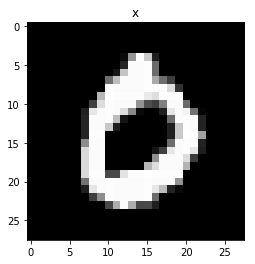

In [100]:
idx = 3
x = X_test[idx]
y = y_test[idx]

plt.imshow(x.reshape(28,28), 'gray')
plt.title('x')
plt.show()

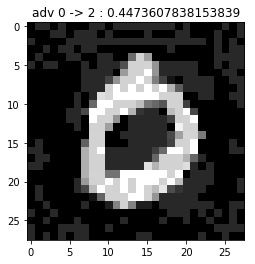

In [111]:
adv = generate_adv(x, y, model_name, 0.164)

pred_class, pred_per = predict(adv, model)
plt.imshow(adv.reshape(28,28), 'gray')
plt.title(f'adv {y} -> {pred_class} : {pred_per}')
plt.show()

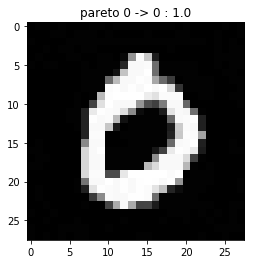

In [102]:
pareto_adv = generate_pareto_adv(x, y, model_name, eps, per)

pred_class, pred_per = predict(pareto_adv, model)
plt.imshow(pareto_adv.reshape(28,28), 'gray')
plt.title(f'pareto {y} -> {pred_class} : {pred_per}')
plt.show()

1


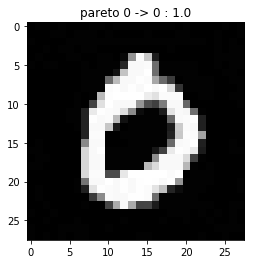

2


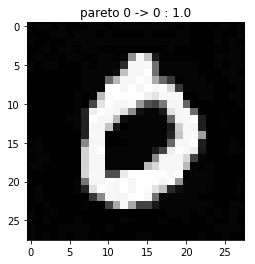

3


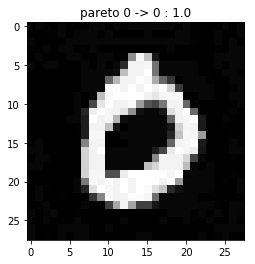

4


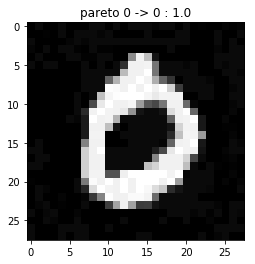

5


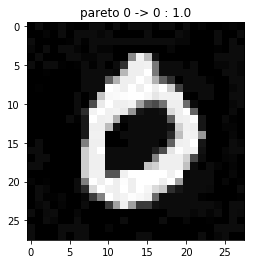

6


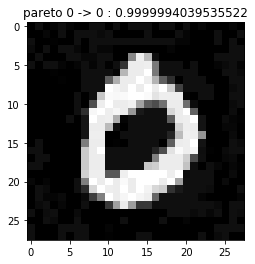

7


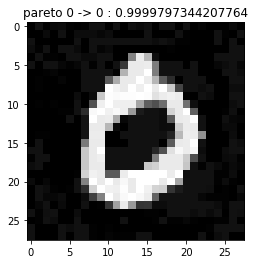

8


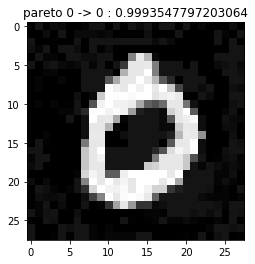

9


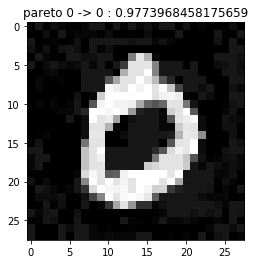

10


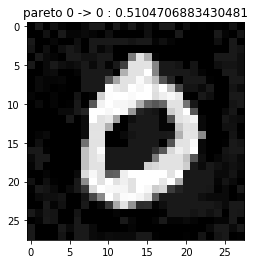

11


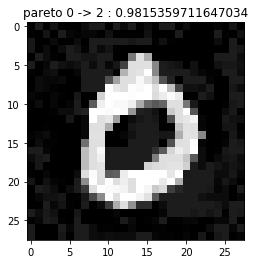

12


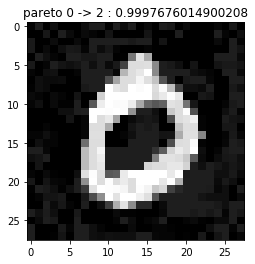

13


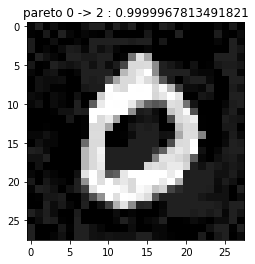

14


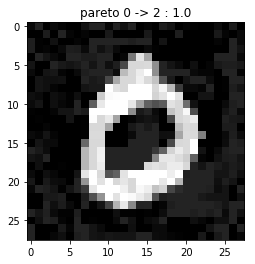

15


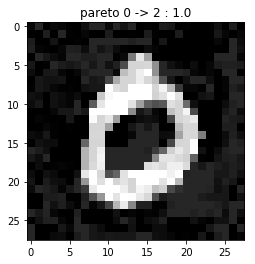

16


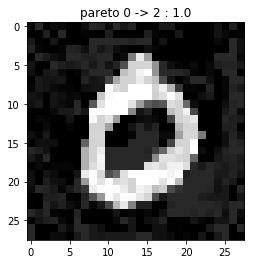

17


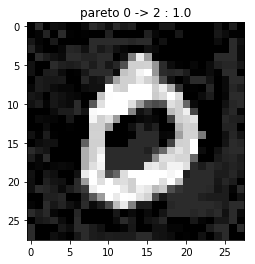

18


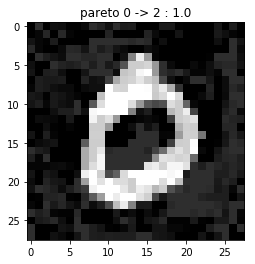

19


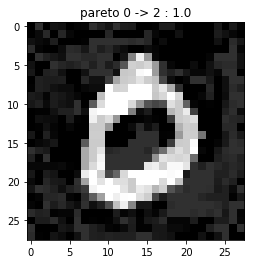

20


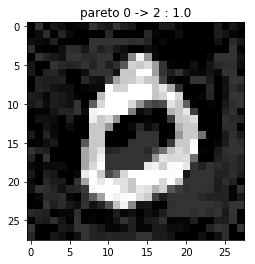

In [103]:
pareto = x.copy()
for i in range(1, iterate+1):
    print(i)
    pareto = generate_pareto_adv(pareto, y, model_name, eps, per)
    
    pred_class, pred_per = predict(pareto, model)
    plt.imshow(pareto.reshape(28,28), 'gray')
    plt.title(f'pareto {y} -> {pred_class} : {pred_per}')
    plt.show()
    
    print('=========================')

In [ ]:
def generate_adv_list(x_list, y_list, model_name, eps):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 100 == 0:
            print(i)
        adv = generate_adv(x, y, model_name, eps)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [ ]:
# adv_test = generate_adv_list(X_test[:max_n], y_test[:max_n], model_name, eps)
# adv_test.shape

In [ ]:
def generate_pareto_adv_list(x_list, y_list, model, eps, per):
    pareto_adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 100 == 0:
            print(i)
        pareto_adv = generate_pareto_adv(x, y, model, eps, per)
        pareto_adv_list.append(pareto_adv)
        
    return np.array(pareto_adv_list)

In [ ]:
# pareto_test = generate_pareto_adv_list(X_test[:max_n], y_test[:max_n], model_name, eps)
# pareto_test.shape

In [ ]:
score = model.evaluate(X_test, y_test_catego, verbose=0)
print('X_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

In [ ]:
score = model.evaluate(X_test[:max_n], y_test_catego[:max_n], verbose=0)
print('X_test')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

In [ ]:
# score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
# print('adv_test')
# print('Test loss :', score[0])
# print('Test accuracy :', score[1])